In [2]:
import numpy as np
import math
import random as rn
import matplotlib.pyplot as plt

rn.seed(1)

In [3]:
# Generate RRT based on Pseudocode of LaValle 1998 Paper
# TODO
# 1. How do we connect to dot?
# 2. Obstacle Avoidance?
# 3. 

In [4]:
# Wrap2Pi
# Wrap around 2Pi for easier understanding
def wrap2pi(x):
    return x%(2*np.pi)

In [5]:
# Build Valid Movement Masking Map
# Implemented from Game Theory example
# n indicates number of grid cells for n x n grid
# Meshgrid X, Y created for n^2 number of cells with x, y values of 0 to xf, yf
n = 21
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X,Y = np.meshgrid(x, y)

# Position function converting position index i_x to position x
def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

# Define Initial, Final position of the aggressor
# Position index of aggressor
i_x0 = (int(0.05*n), int(0.05*n))
i_xf = (int(0.95*n), int(0.95*n))
# Position of aggressor
x0 = position(i_x0)
xf = position(i_xf)
print("x0: {}, xf: {}".format(x0, xf))

# Building Setup
# Set nB number of buildings
# building_i indicates 4 corners of the building generated in the field
nB = 2
building1 = np.array([0, 0.3, 0.25, 0.75])
building2 = np.array([0.7, 1, 0.25, 0.75])
building = [building1, building2]

x0: [0.05 0.05], xf: [0.95 0.95]


In [6]:
# Camera Setup
# camx: x coordinate of camera
# camy: y coordinate of camera
# cam_direc: Center of camera tilt angle limits
camx = np.array([.3, .7, .3, .7])
camy = np.array([.25, .25, .75, .75])
cam_direc = np.array([np.pi*7/4, np.pi*5/4, np.pi*1/4, np.pi*3/4])

# Camera Hardware Constants
# These values are pre-determined by hardware spec given from manufacturer
tilt_limit = [0, np.pi]
fov_ang = np.deg2rad(20) # [rad]
#fov_rng = 0.475 # [m]
fov_rng = 0.2 # [m]


# Function computing a vector containing camera angle at given specific time t
def fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t):
    # Compute Camera angle (centerline of FOV) at each timestamp t
    ang_prev = start_ang
    fov_ang_vec = np.zeros(len(t)-1)
    dt = t[1]-t[0]
    
    # Iteration until it hits the angle limit
    iter_lim = 2*(ang_lim[1]-ang_lim[0])/rot_vel
    for i in range(len(t)-1):
        if i < iter_lim/2:
            fov_ang_curr = ang_prev + rot_vel*dt
        # Camera rotates back once reached its rotation limit
        else:
            fov_ang_curr = ang_prev - rot_vel*dt
        ang_prev = fov_ang_curr
        
        # Store the computed current angle into storage vector
        fov_ang_vec[i] = fov_ang_curr
    return fov_ang_vec

# Function computing a camera properites
# Assume all cameras are identical
def camera_setup(camx, camy, cam_direc):
    # n_cam: number of camera
    # rot_vel: angular velocity of camera movement
    n_cam = len(camx)
    rot_vel = 2*(tilt_limit[1]-tilt_limit[0])/n # [rad/unit time]
    endtime = int(tilt_limit[1]*2/rot_vel)
    
    # Initialize empty storages
    ang_lim = np.zeros((n_cam,2))
    start_ang = np.zeros((n_cam,1))    
    tvec = np.zeros((n_cam, int(tilt_limit[1]*2/rot_vel)))
    camvec = np.zeros((n_cam, tvec.shape[1]-1))
    
    # Compute camera properties for each camera
    # campos: position of the camera
    # start_ang: angle of the camera at given time
    # tvec: time vector which camera is operating
    # ang_lim: Limit of angle which camera can tilt
    # camvec: a vector including camera FOV's angle at given t
    for i in range(n_cam):
        ang_limi = [cam_direc[i]-(tilt_limit[1]-tilt_limit[0])/2, cam_direc[i]+(tilt_limit[1]-tilt_limit[0])/2]
        start_angi = ang_limi[0] # [rad]
        ti = np.linspace(0, endtime-1, endtime)
        
        # Store computed variables
        ang_lim[i,:] = ang_limi
        start_ang[i] = start_angi
        tvec[i,:] = ti
        
        # Compute fov_cam
        fov_ang_veci = fov_cam(start_angi, ang_limi, rot_vel, fov_ang, fov_rng, ti)
        camvec[i,:] = fov_ang_veci
        
    # Camera Positoin
    campos = np.array([camx, camy]).transpose()

    return campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec

# Obtain camera properties
campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec = camera_setup(camx, camy, cam_direc)

# Check number mismatch
for i in range(n_cam):
    print("campos: {}, {}".format(campos[i,0], campos[i,1]))
print("camvec length: {}".format(len(camvec[0])))

# Define Initial, Final position of the Camera FOV (centerline)
end_in = np.array([int(len(tvec[0])/2), int(len(tvec[1])/2), int(len(tvec[2])/2), int(len(tvec[2])/2)]) #random.randint(0, len(t)-1)
end_ang = np.array([camvec[0, end_in[0]], camvec[1, end_in[1]], camvec[2, end_in[2]], camvec[3, end_in[3]]]) # Arbirary number for now
if len(end_in) != n_cam:
    raise Exception("number of camera mismatch")
    print("end_index: {}, FOV angle at final point[deg]: {}".format(end_in, np.rad2deg(end_ang)))
for i in range(n_cam):
    print("end_index: {}, FOV angle at final point[deg]: {}, Tilt Limit: {}".format(end_in[i], np.rad2deg(end_ang[i]), np.rad2deg(ang_lim[i])))

campos: 0.3, 0.25
campos: 0.7, 0.25
campos: 0.3, 0.75
campos: 0.7, 0.75
camvec length: 20
end_index: 10, FOV angle at final point[deg]: 413.5714285714288, Tilt Limit: [225. 405.]
end_index: 10, FOV angle at final point[deg]: 323.5714285714286, Tilt Limit: [135. 315.]
end_index: 10, FOV angle at final point[deg]: 143.57142857142858, Tilt Limit: [-45. 135.]
end_index: 10, FOV angle at final point[deg]: 233.57142857142856, Tilt Limit: [ 45. 225.]


In [7]:
# Movement Map Masking
# Current Movement Map = Static Map + Dyanmic Map
# Assume camera movements are periodic. Take camera movement at discrete timestep for each timestep, while having a static map as global constant
# Store dynamic map in python dictionary with each timestamp being a key to access

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

# Bound outside of camera FOV
def bound_cam(i_x, campos, fov_ang_curr, fov_ang, fov_rng):
    # Convert i_x to position
    i_xPos = position(i_x)
    # distance to node
    dist = np.sqrt((campos[0]-i_xPos[0])**2 + (campos[1]-i_xPos[1])**2)
    # Angle to node
    ang = wrap2pi(np.arctan2(i_xPos[1]-campos[1], i_xPos[0]-campos[0]))
    
    return wrap2pi(fov_ang_curr+fov_ang/2)-ang>=0 and wrap2pi(fov_ang_curr-fov_ang/2)-ang<=0 and fov_rng - dist >= 0

def bound_building(i_x, building):
    # building: [x0, x1, y0, y1]
    currpos = position(i_x)
    bcheck = np.zeros((nB,1))
    for b in range(nB):
        bnow = building[b]
        bcheck[b] = (currpos[0] >= bnow[0] and currpos[0] <= bnow[1] and currpos[1] >= bnow[2] and currpos[1] <= bnow[3])
    sumcheck = 0
    for b in range(nB):
        sumcheck += bcheck[b]
    return sumcheck

def static_movement_map(X, Y):
    # Static Movement Map
    nH = len(X)
    nV = len(X[0])
    
    # For (x, y) coordinate, check if this is within the field bound while outside of building bound
    static_map = np.zeros((nH, nV))
    for i in range(len(X)):
        for j in range(len(Y)):
            # Check if the (i,j) is within field bound
            within_bound = bound((i, j))
            # check if the (i,j) is outside building bound
            within_building = bound_building((i,j), building)
            
            # If we are within_bound but not in building >> True
            # else >> False
            static_map[i,j] = within_bound and not within_building
    return static_map

def dynamic_movement_map(X, Y, tvec, camvec):
    # Dynamic Movement Map at time t from tvec
    # Obtain camera FOV position at time t
    nH = len(X)
    nV = len(X[0])
    
    dynamic_map = {}
    for tk in range(len(tvec[0])-1):
        # At tk, we know where ith camera's angle theta_ik is facing
        currkey = str(tk)
        
        # Check if each grid cells are included in camera FOV
        # If outside camera FOV >> True
        # If inside camera FOV >> False
        map_k = np.zeros((nH, nV))
        for i in range(len(X)):
            for j in range(len(Y)):
                camcheck = np.zeros(n_cam)
                for k in range(n_cam):
                    # Check if gird coordinate (i,j) is in kth camera's FOV
                    camcheck[k] = bound_cam((i,j), campos[k], camvec[k, tk], fov_ang, fov_rng)
                map_k[i,j] = not camcheck.any()
                
        dynamic_map[currkey] = map_k
        
        
    return dynamic_map

def current_movement_map(static_map, dynamic_map, tvec):
    # Take static map and add dynamic map at time tk
    # to generate current movement map
    nH = len(X)
    nV = len(X[0])
    current_map = {}
    # At each tk, generate current map and store as dictionary
    for tk in range(len(tvec[0])-1):
        currkey = str(tk)
        currmap_k = np.zeros((nH, nV))
        for i in range(len(X)):
            for j in range(len(Y)):
                currmap_k[i,j] = static_map[i,j] and dynamic_map[currkey][i,j]
        current_map[currkey] = currmap_k
    return current_map

static_map = static_movement_map(X, Y)
dynamic_map = dynamic_movement_map(X, Y, tvec, camvec)
current_map = current_movement_map(static_map, dynamic_map, tvec)

In [8]:
# Miscelleneous tools
def reverse_pos(pos):
    xp = pos[0]
    yp = pos[1]
   
    xcost = 1
    ycost = 1
    for i in range(len(x)):
        if abs(x[i] - xp) < xcost:
            xcost = abs(x[i]-xp)
            ix = i
    for j in range(len(y)):
        if y[j] - yp < ycost:
            ycost = abs(y[j]-yp)
            iy = j
    
    return (ix, iy)

In [9]:
# Generate RRT
# Based on LaValle Paper
def build_RRT(qinit, delq):
    # Input
    # qinit: Initial node (In index)
    # K: Number of vertices
    # delq: time difference in discrete step
    
    # Output
    # G: Group of Vertex and Edge
    
    # Miscelleneous
    counter = 0
    k = 0
    range_tol = 1
    
    # Setup
    G = {}
    keyList = ['vertex', 'edge']
    for i in keyList:
        G[i] = []
    G['vertex'].append(qinit)
    
    # Generate different random nodes until we reach final point
    repeat = True
    while repeat:
        # Get current discrete time index
        ct = counter%(n-1)
        
        # Generate New Random Point
        qrand = rand_conf()
        
        # Find nearest vertex from G
        qnear = nearest_vertex(qrand, G['vertex'])
        
        # Move in direction to qrand for delq amount
        qnew = new_conf(qnear, qrand, delq)
        
        # Check incremented movement is within valid movement map
        check_q = check_validity(qnew, current_map[str(ct)])
        if check_q:
            # Generate edge between qnear and closest vertex in G
            qedge = gen_edge(qnew, G['vertex'])

            # Update
            G['vertex'].append(qnew)
            G['edge'].append(qedge)
            counter += 1
            k += 1
            
            #plot_field(G, counter, ct)

            # Check if we reached proximity for i_xf
            if rangeTo(qnew, i_xf) <= range_tol:
                print("{} iterations to reach xf".format(counter))
                print("xf reached at dynamic map index {}".format(ct))
                G['edge'].append([[qnew[0], i_xf[0]], [qnew[1], i_xf[1]]])
                
                # End while loop
                repeat = False
                
                # Plot Graph
                plot_field(G, counter, ct)
                
                return counter, G
                break
        
        
def rand_conf():
    # Generate random node
    return (rn.randint(0,n), rn.randint(0,n))

def rangeTo(x0, x1):
    return np.sqrt((x0[0] - x1[0])**2 + (x0[1] - x1[1])**2)

def nearest_vertex(q, G):
    # Obtain nearest vertex in G
    d = math.inf
    
    for g in G:
        if rangeTo(q, g) < d:
            gnew = g
            d = rangeTo(q, g)
    return gnew

def new_conf(q0, q1, delq):
    theta = np.arctan2(q1[1]-q0[1], q1[0]-q0[0])
    return (q0[0]+delq*np.cos(theta), q0[1]+delq*np.sin(theta))

def gen_edge(q0, G):
    gc = nearest_vertex(q0, G)
    return [[q0[0], gc[0]], [q0[1], gc[1]]]

def check_validity(q0, mmap):
    dist = []
    grid = []
    for i in range(len(X)):
        for j in range(len(Y)):
            dist.append(rangeTo((i,j), q0))
            grid.append((i,j))
    min_ind = dist.index(min(dist))
    currGrid = grid[min_ind]
    qx = currGrid[0]
    qy = currGrid[1]
    
    return bound(currGrid) and mmap[qx, qy]

def plot_field(G, counter, ct):
    fig = plt.figure()           
    # Plot Vertex
    for g in G['vertex']:
        plt.plot(g[0], g[1], '.r')

    # Plot Edge
    for e in G['edge']:
        plt.plot(e[0], e[1], '-r')

    # Plot Building
    for b in range(nB):
        bcoor = building[b]
        bcoor1 = reverse_pos(bcoor[0:2])
        bcoor2 = reverse_pos(bcoor[2:4])
        plt.plot([bcoor1[0], bcoor1[1]], [bcoor2[0], bcoor2[0]], '-k')
        plt.plot([bcoor1[0], bcoor1[1]], [bcoor2[1], bcoor2[1]], '-k')
        plt.plot([bcoor1[0], bcoor1[0]], [bcoor2[0], bcoor2[1]], '-k')
        plt.plot([bcoor1[1], bcoor1[1]], [bcoor2[0], bcoor2[1]], '-k')

    for ind in range(n_cam):
        # Plot Camera Position
        temp = reverse_pos(campos[ind])
        plt.plot(temp[0], temp[1], 'ok', label='camera pos' if ind == 0 else "")

        # Plot Camera FOV
        k = ct
        theta = camvec[ind, k]
        xend = temp[0]+fov_rng*n*np.cos(theta)
        yend = temp[1]+fov_rng*n*np.sin(theta)
        #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

        # FOV LOS
        h = (fov_rng*n)*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + (fov_rng*n)**2)

        xprime1 = [temp[0], temp[0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
        yprime1 = [temp[1], temp[1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
        xprime2 = [temp[0], temp[0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
        yprime2 = [temp[1], temp[1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-k')
        plt.plot(xprime2, yprime2, '-k')


    plt.plot(i_x0[0], i_x0[1], 'ob') # Initial Point
    plt.plot(i_xf[0], i_xf[1], 'xb') # Final Point

    # Plot Settings
    plt.grid()
    plt.axis('square')
    tol = 0.5
    plt.xlim(-tol, n+tol)
    plt.ylim(-tol, n+tol)
    #plt.legend(loc="upper right")
    plt.title("Timestep: {}".format(counter))
    plt.show()

In [12]:
# Connect vertex to reach final destination
def opt_path(G):
    Gv = G['vertex']
    Ge = G['edge']
    
    # Starting from x0, check all edge available for the 
    

216 iterations to reach xf
xf reached at dynamic map index 15


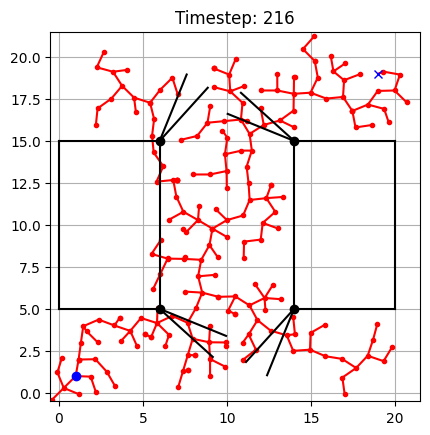

In [10]:
iter_G, G = build_RRT(i_x0, 1)

In [173]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML